**Tabla de contenido**

- [Examinando el modelo VAR](#Examinando-el-modelo-VAR)
- [Diseñando un procedimiento de modelado para el modelo VAR(p)](#Diseñando-un-procedimiento-de-modelado-para-el-modelo-VA)
    - [Explorando el test de causalidad de Granger](#Explorando-el-test-de-causalidad-de-Granger)
- [Pronosticando el ingreso disponible real y el consumo real](#Pronosticando-el-ingreso-disponible-real-y-el-consumo-real)
- [Próximos pasos](#Proximos-pasos)
- [Resumen](#Resumen)

En el último capítulo, viste cómo el modelo SARIMAX se puede utilizar para incluir el impacto de variables exógenas en una serie temporal. Con el modelo SARIMAX, la relación es unidireccional: asumimos que la variable exógena tiene un impacto en el objetivo solamente.

Sin embargo, es posible que dos series temporales tengan una relación bidireccional, lo que significa que la serie temporal t1 es un predictor de la serie temporal t2, y la serie temporal t2 también es un predictor para la serie temporal t1. En tal caso, sería útil tener un modelo que pueda tener en cuenta esta relación bidireccional y generar predicciones para ambas series temporales simultáneamente.

Esto nos lleva al `modelo de autorregresión vectorial (VAR)`. Este modelo en particular nos permite captar la relación entre múltiples series temporales a medida que cambian con el tiempo. Eso, a su vez, nos permite producir pronósticos para muchas series temporales simultáneamente, realizando así pronósticos multivariantes.

# Examinando el modelo VAR

`El modelo de autorregresión vectorial (VAR) captura la relación entre múltiples series a medida que cambian con el tiempo.` En este modelo, cada serie tiene un impacto en las otras, a diferencia del modelo SARIMAX donde la variable exógena tenía un impacto en el objetivo, pero no al revés. Recuerda que en el capítulo 9 usamos las variables realcons, realinv, realgovt, realdpi, cpi, m1 y tbilrate como predictores para realgdp, pero no consideramos cómo realgdp puede afectar a ninguna de esas variables. Esa es la razón por la cual usamos el modelo SARIMAX en ese caso.

Puede que hayas notado el regreso de la autorregresión, lo que nos lleva de vuelta al modelo AR(p) del capítulo 5. Esta es una buena intuición, ya que el modelo VAR se puede ver como una generalización del modelo AR(p) para permitir la previsión de múltiples series temporales. Por lo tanto, también podemos denotar el modelo VAR como VAR(p), donde p es el orden y tiene el mismo significado que en el modelo AR(p).

`Recuerda que AR(p) expresa el valor de una serie temporal como una combinación lineal de una constante` $C$, el término de error presente $ϵ_t$, que también es ruido blanco, y los valores pasados de la serie $y_{t–p}$. La magnitud de la influencia de los valores pasados en el valor presente se denota como $ϕ_p$, que representa los coeficientes del modelo AR(p), como se muestra en la siguiente ecuación.

$$y_t = C + ϕ_1y_{t–1} + ϕ_2y_{t–2} +⋅⋅⋅+ ϕ_py_{t–p} + ϵ_t$$

Podemos simplemente extender la anterior ecuación  para permitir que se modelen múltiples series de tiempo, donde cada una tiene un impacto en las otras.

Para simplificar, consideremos un sistema con dos series temporales, denominadas $y_{1,t}$ y $y_{2,t}$, y un orden de 1, lo que significa que p = 1. Luego, utilizando notación de matrices, el modelo VAR(1) se puede expresar como la siguiente ecuación.
$$
\begin{bmatrix}
y_{1,t} \\
y_{2,t}
\end{bmatrix}
=
\begin{bmatrix}
C_1 \\
C_2
\end{bmatrix}
+
\begin{bmatrix}
\phi_{1,1} & \phi_{1,2} \\
\phi_{2,1} & \phi_{2,2}
\end{bmatrix}
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1}
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_{1,t} \\
\epsilon_{2,t}
\end{bmatrix}
$$

Al realizar la multiplicación de matrices, tenemos:

$y_{1,t} = C_1 + ϕ_{1,1}y_{1,t–1} + ϕ_{1,2}y_{2,t–1} + ϵ_{1,t}$

$y_{2,t} = C_2 + ϕ_{2,1}y_{1,t–1} + ϕ_{2,2}y_{2,t–1} + ϵ_{2,t}$

El modelo VAR(p) solo es válido si ambas series son útiles para predecirse mutuamente. Observar la forma general de las series a lo largo del tiempo no es suficiente para respaldar esa hipótesis. En cambio, debemos aplicar `la prueba de causalidad de Granger, que es una prueba de hipótesis estadística para determinar si una serie temporal es predictiva de otra`. Solo tras el éxito de esta prueba podemos aplicar el modelo VAR para hacer predicciones. Este es un paso importante en nuestro procedimiento de modelado al utilizar un modelo VAR.

# Diseñando un procedimiento de modelado para el modelo VAR

El modelo VAR(p) requiere una versión ligeramente modificada del procedimiento de modelado que hemos estado utilizando. La modificación más notable es la adición de la prueba de causalidad de Granger, ya que el modelo VAR asume que los valores pasados de ambas series temporales son significativamente predictivos de la otra serie temporal.

![VAR(p)](fig/VAR.png)

Figura. Procedimiento de modelado para el modelo VAR(p). Es muy similar a los procedimientos de modelado que hemos estado usando desde la introducción del modelo ARMA(p, q), pero esta vez estamos ajustando diferentes modelos VAR(p) y seleccionando el que tiene el menor AIC. Luego realizamos la prueba de causalidad de Granger. Si falla, el modelo VAR(p) no es válido y no continuaremos con el procedimiento. Por otro lado, si la prueba pasa, realizamos un análisis de residuos. Si los residuos son similares al ruido blanco, el modelo VAR(p) se puede utilizar para pronósticos.


`La principal diferencia aquí es que solo enumeramos valores para el orden p`, ya que estamos ajustando diferentes modelos VAR(p) a los datos. Luego, una vez que se ha seleccionado el modelo con el AIC más bajo, realizamos la prueba de causalidad de Granger. Esta prueba determina si los valores pasados de una serie temporal son estadísticamente significativos para pronosticar otra serie temporal. Es importante verificar esta relación porque el modelo VAR(p) utiliza valores pasados de una serie temporal para pronosticar otra.

`Si la prueba de causalidad de Granger falla, no podemos decir que los valores pasados de una serie temporal sean predictivos de la otra serie temporal`. En ese caso, el modelo VAR(p) se vuelve inválido y debemos recurrir a una variación del modelo SARIMAX para pronosticar la serie temporal. `Por otro lado, si la prueba de causalidad de Granger pasa, podemos reanudar el procedimiento con el análisis de residuos`. Como antes, si los residuos están cerca del ruido blanco, podemos usar el modelo VAR(p) seleccionado para hacer pronósticos.

Antes de pasar a aplicar este procedimiento de modelado, vale la pena dedicar un tiempo a explorar la prueba de causalidad de Granger con más detalle.

## Explorando el test de causalidad de Granger

`Como se muestra en la sección anterior, el modelo VAR(p) asume que cada serie temporal tiene un impacto en otra.` Por lo tanto, es importante probar si esta relación realmente existe. De lo contrario, estaríamos asumiendo una relación que no existe, lo que introduciría errores en el modelo y haría que nuestras predicciones fueran inválidas e inciertas.

Por lo tanto, utilizamos la prueba de causalidad de Granger. Esta es una prueba estadística que nos ayuda a determinar si los valores pasados de una serie temporal $y_{2,t}$ pueden ayudar a predecir la serie temporal $y_{1,t}$. Si ese es el caso, entonces decimos que $y_{2,t}$ causa a $y_{1,t}$ según Granger.

`Tenga en cuenta que la prueba de causalidad de Granger está restringida a la causalidad predictiva`, ya que solo estamos determinando si los valores pasados de una serie temporal son estadísticamente significativos para predecir otra serie temporal. Además, la prueba requiere que ambas series temporales sean estacionarias para que los resultados sean válidos. También, la prueba de causalidad de `Granger solo evalúa la causalidad en una dirección`; debemos repetir la prueba para verificar que $y_{1,t}$ también causa de Granger a $y_{2,t}$ para que el modelo VAR sea válido. De lo contrario, debemos recurrir al modelo SARIMAX y predecir cada serie temporal por separado.

La hipótesis nula para esta prueba establece que $y_{2,t}$ no causa de Granger a $y_{1,t}$. Nuevamente, utilizaremos el valor p con un valor crítico de 0.05 para determinar si rechazaremos la hipótesis nula o no. En el caso de que el valor p devuelto de la prueba de causalidad de Granger sea menor que 0.05, podemos rechazar la hipótesis nula y decir que $y_{2,t}$ causa de Granger a $y_{1,t}$.

`Vimos que la prueba de causalidad de Granger se realiza después de seleccionar el modelo VAR(p). Esto se debe a que la prueba requiere que especifiquemos el número de rezagos a incluir en la prueba, lo cual es equivalente al orden del modelo`. Por ejemplo, si el modelo VAR(p) seleccionado es de orden 3, la prueba de causalidad de Granger determinará si los tres valores pasados de una serie temporal son estadísticamente significativos para predecir la otra serie temporal.

La biblioteca statsmodels incluye convenientemente la prueba de causalidad de Granger, que aplicaremos en la siguiente sección cuando pronostiquemos tanto el consumo real como el ingreso disponible real.

# Pronosticando el ingreso disponible real y el consumo real

Habiendo examinado el modelo VAR(p) y diseñado un procedimiento de modelado para él, ahora estamos listos para aplicarlo a la previsión tanto del ingreso disponible real como del consumo real en los Estados Unidos. Usaremos el mismo conjunto de datos que en el capítulo anterior, que contiene los datos macroeconómicos entre 1959 y 2009.

In [1]:
import statsmodels.api as sm

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


Ahora podemos trazar nuestras dos variables de interés, que son el ingreso disponible real, denotado como realdpi en el conjunto de datos, y el consumo real, denotado como realcons.

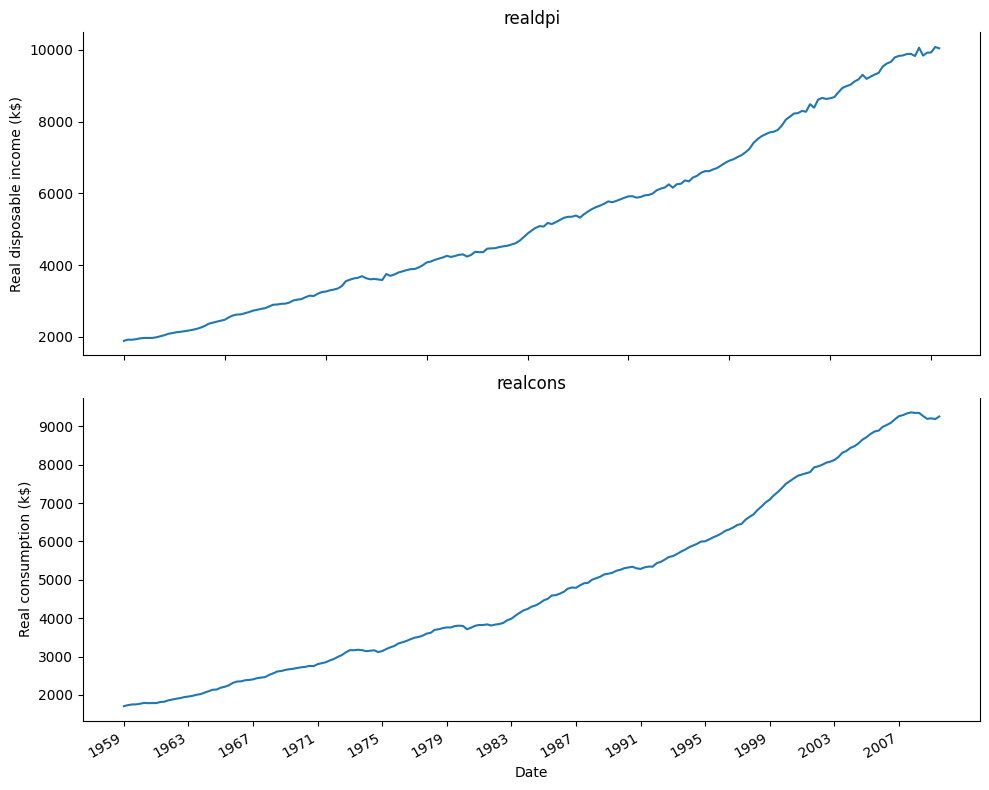

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
fig.autofmt_xdate()
plt.tight_layout()

En la figura se puede ver que ambas curvas tienen una forma muy similar a lo largo del tiempo, lo que intuitivamente las convierte en buenos candidatos para un modelo VAR(p). Es razonable pensar que con un ingreso disponible más alto, el consumo probablemente sea alto, así como un mayor consumo puede ser un signo de un ingreso disponible más alto. Por supuesto, esta hipótesis tendrá que ser probada utilizando la prueba de causalidad de Granger más adelante en el procedimiento de modelado.

Hemos recopilado los datos, así que ahora debemos determinar si las series temporales son estacionarias.


In [3]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])
print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
print('\n---------------------\n')
ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])
print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.986025351954683
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050964
p-value: 0.9976992503412904


`Tenga en cuenta que ambas series temporales deben ser estacionarias antes de ser utilizadas en el modelo VAR(p).`

Para ambas variables, la prueba ADF arroja un valor p de 1.0. Por lo tanto, no podemos rechazar la hipótesis nula y concluimos que ambas series temporales no son estacionarias, como se esperaba.

Aplicaremos una transformación para hacer que sean estacionarias. Específicamente, diferenciaremos ambas series y probaremos la estacionariedad nuevamente.

In [4]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])
print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])
print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673007
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


En ambos casos, el valor p es menor que 0.05. Por lo tanto, rechazamos la hipótesis nula y concluimos que ambas series temporales son estacionarias. Como se mencionó antes, el modelo VAR(p) requiere que las series temporales sean estacionarias. Por lo tanto, podemos usar las series transformadas para modelar y necesitaremos integrar las predicciones para devolverlas a sus escalas originales.

Ahora estamos en el paso de ajustar muchos modelos VAR(p) para seleccionar el que tenga el menor criterio de información de Akaike (AIC). Escribiremos una función, optimize_VAR, para ajustar muchos modelos VAR(p) mientras variamos el orden p. Esta función devolverá un DataFrame ordenado en orden ascendente de AIC. Esta función se muestra en el siguiente listado.


In [5]:
import pandas as pd
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.varmax import VARMAX
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    results = []
    for i in tqdm(range(15)): #1
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
        aic = model.aic
        results.append([i, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df


Ahora podemos usar esta función para seleccionar el orden p que minimiza el AIC. Primero, sin embargo, debemos definir los conjuntos de entrenamiento y prueba. En este caso, usaremos el 80% de los datos para el entrenamiento y el 20% para la prueba. Esto significa que los últimos 40 puntos de datos se utilizarán para la prueba, y el resto se utilizará para el entrenamiento. Recuerda que el modelo VAR(p) requiere que ambas series sean estacionarias. Por lo tanto, dividiremos el conjunto de datos diferenciado y alimentaremos el conjunto de entrenamiento diferenciado a la función optimize_VAR.

In [6]:
endog = macro_econ_data[['realdpi', 'realcons']]
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:] # La diferencia de ambas series, ya que la prueba ADF muestra que una diferenciación de primer orden las hace estacionarias.
train = endog_diff[:162]
test = endog_diff[162:]
result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dips. After release 0.14, this will raise.
  warnings.warn(
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dips. After release 0.14, this will raise.
  warnings.warn(
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/base/optimize

,p,AIC
0,3,3123.070076
1,5,3123.708523
2,6,3126.855595
3,4,3129.194027
4,2,3130.091668
5,7,3133.398198
6,1,3134.333343
7,8,3137.149014
8,9,3140.367179
9,10,3147.838979


Ejecutar la función devuelve un DataFrame en el que vemos que p = 3 tiene el valor más bajo de AIC de todos. Por lo tanto, el modelo seleccionado es un modelo VAR(3), lo que significa que se utilizan los tres valores pasados de cada serie temporal para predecir las otras series temporales.

Siguiendo el procedimiento de modelado, ahora debemos usar el test de causalidad de Granger. Recuerda que el modelo VAR asume que los valores pasados de realcons son útiles para predecir realdpi y que los valores pasados de realdpi son útiles para predecir realcons. Esta relación debe ser probada. Si el test de causalidad de Granger devuelve un valor p mayor que 0.05, no podemos rechazar la hipótesis nula, lo que significa que las variables no se causan mutuamente, y el modelo es inválido. Por otro lado, un valor p menor que 0.05 nos permitirá rechazar la hipótesis nula, validando así el modelo VAR(3), lo que significa que podemos continuar con el procedimiento de modelado.

Realizaremos la prueba de causalidad de Granger para ambas variables, utilizando la función `grangercausalitytests` de la biblioteca `statsmodels`. Recuerda que las series deben ser estacionarias para la prueba de causalidad de Granger, por eso se diferencian al ser pasadas a la función. Además, especificamos el número de rezagos para la prueba, que en este caso es 3, ya que el paso de selección del modelo devolvió p = 3.

1. La función prueba si la segunda variable causa de Granger a la primera. Aquí probamos si realcons causa de Granger a realdpi. Luego pasamos el número de rezagos en una lista, que en nuestro caso es 3. Tenga en cuenta que las series se diferencian para hacerlas estacionarias.
2. Aquí probamos si realdpi causa grangermente a realcons.

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests

print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi','realcons']].diff()[1:], [3]) #❶
print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons','realdpi']].diff()[1:], [3]) #❷

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


Realizar la prueba de causalidad de Granger para ambas variables devuelve un valor p menor que 0.05 en ambos casos. Por lo tanto, podemos rechazar la hipótesis nula y concluir que realdpi causa a Granger realcons, y realcons causa a Granger realdpi. Nuestro modelo VAR(3) es, por lo tanto, válido. En el caso de que una variable no cause a Granger a la otra, el modelo VAR(p) se vuelve inválido y no puede ser utilizado. En ese caso, debemos usar el modelo SARIMAX y predecir cada serie de tiempo individualmente.

Ahora podemos pasar al análisis residual. Para este paso, primero ajustamos el modelo VAR(3) en nuestro conjunto de entrenamiento.

In [8]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

Entonces podemos usar la función plot_diagnostics para trazar un histograma de los residuales, el gráfico Q-Q y el correlograma. Sin embargo, debemos estudiar los residuales de dos variables aquí, ya que estamos modelando tanto realdpi como realcons.

`Primero, centrémonos en los residuos para realdpi.`
1. Al pasar variable=0 se especifica que queremos gráficos para los residuos de realdpi, ya que es la primera variable que se pasó al modelo VAR.

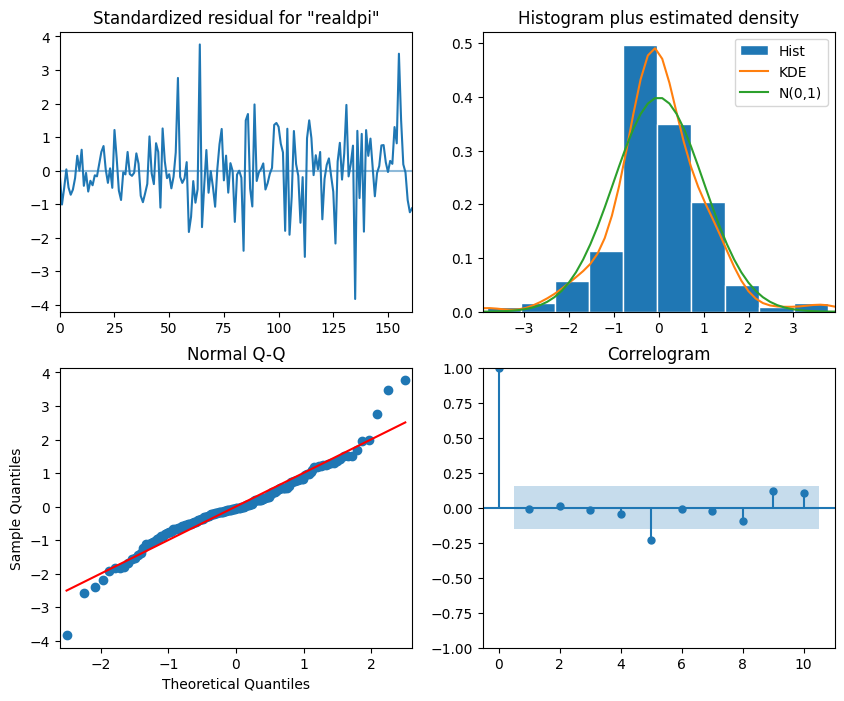

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);#1

Figura. Análisis de residuos de realdpi. Los residuos estandarizados parecen no tener tendencia y tener varianza constante, lo que está en línea con el ruido blanco. El histograma también se asemeja estrechamente a la forma de una distribución normal. Esto es respaldado adicionalmente por el gráfico Q-Q, que muestra una línea bastante recta que se encuentra en y = x, aunque podemos ver cierta curvatura en los extremos. Finalmente, el correlograma no muestra coeficientes significativos excepto en el rezago 5. Sin embargo, esto probablemente se deba al azar, ya que no hay coeficientes significativos precedentes. Por lo tanto, podemos concluir que los residuos están cerca del ruido blanco.

Ahora podemos pasar a analizar los residuos de realcons.
1. Pasar la variable=1 especifica que queremos los gráficos de los residuos para realcons, ya que fue la segunda variable pasada en el modelo.

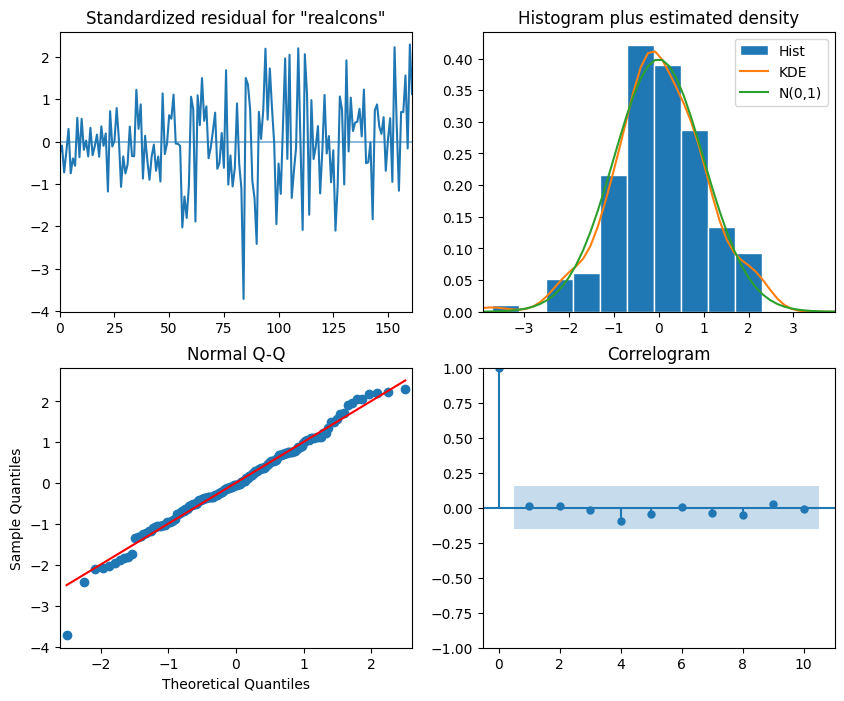

In [10]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);#❶

Figura. Análisis de residuos de realcons. El gráfico en la parte superior izquierda muestra los residuos a lo largo del tiempo, y se puede ver que no hay tendencia y varianza constante, lo cual está en línea con el comportamiento del ruido blanco. En la parte superior derecha, la distribución es muy cercana a una distribución normal. Esto se apoya aún más en el gráfico Q-Q en la parte inferior izquierda, que muestra una línea bastante recta que se encuentra en y = x. Finalmente, el correlograma en la parte inferior derecha muestra que no hay coeficientes de autocorrelación significativos después del rezago 0. Por lo tanto, los residuos son cercanos al ruido blanco.

Una vez que se haya realizado el análisis cualitativo, podemos pasar al análisis cuantitativo utilizando la prueba de Ljung-Box. Recuerda que la hipótesis nula de la prueba de Ljung-Box establece que los residuos son independientes y no correlacionados.

Por lo tanto, para que los residuales se comporten como ruido blanco, la prueba debe devolver valores p que sean mayores que 0.05, en cuyo caso no rechazamos la hipótesis nula.


In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox
realgdp_residuals = best_model_fit.resid['realdpi']
lb_test = acorr_ljungbox(realgdp_residuals, lags=np.arange(1, 11))  
# Extraer solo los p-values como array
pvalue = lb_test["lb_pvalue"].values
print(pvalue)

[0.91410979 0.98541728 0.99457731 0.98423729 0.10349423 0.16446282
 0.23380683 0.21256248 0.1487083  0.12191232]


Ejecutar la prueba de Ljung-Box en los residuos de realdpi devuelve valores p que son todos mayores que 0.05. Por lo tanto, no rechazamos la hipótesis nula, lo que significa que los residuos no están correlacionados e independientes, al igual que el ruido blanco.

In [12]:
realcons_residuals = best_model_fit.resid['realcons']
lb_test = acorr_ljungbox(realcons_residuals, lags=np.arange(1, 11))  
# Extraer solo los p-values como array
pvalue = lb_test["lb_pvalue"].values
print(pvalue)


[0.87734341 0.96628082 0.9953102  0.99358499 0.99592573 0.99241042
 0.99457988 0.97604889 0.98252691 0.99168344]


A continuación, realizaremos la prueba sobre los residuos de realcons. Esta prueba devuelve valores p que son todos mayores que 0.05. Nuevamente, no rechazamos la hipótesis nula, lo que significa que los residuos no están correlacionados e independientes, al igual que el ruido blanco.

Dado que el modelo aprobó tanto los aspectos cualitativos como cuantitativos del análisis residual, podemos pasar a predecir realcons y realdpi utilizando un modelo VAR(3). Compararemos el modelo VAR(3) con una línea base que simplemente predice el último valor observado. Pronosticaremos cuatro pasos en el futuro, lo que equivale a pronosticar un año completo ya que los datos se muestrean trimestralmente. Por lo tanto, realizaremos un pronóstico rodante cuatro pasos en el futuro a lo largo de toda la longitud del conjunto de prueba.

Para hacerlo, usaremos la función rolling_forecast que hemos definido muchas veces en los últimos capítulos. Esta vez, aplicaremos algunas ligeras modificaciones para acomodar el modelo VAR(3). Necesitará generar predicciones tanto para realdpi como para realcons, por lo que debemos devolver dos listas que contengan las previsiones. El siguiente listado muestra el código de la función rolling_forecast.

`función rolling_forecast`

1. Inicializa dos listas vacías para contener las predicciones de realdpi y realcons.
2. Extraer las predicciones para realdpi.
3. Extraer las predicciones para realcons.
4. Amplía las listas con las nuevas predicciones para cada variable.
5. Devuelve ambas listas de predicciones para realdpi y realcons.
6. Para la línea base, también utilizaremos dos listas para almacenar las predicciones para cada variable y las devolveremos al final.


In [13]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'VAR':
        realdpi_pred_VAR = [] #1
        realcons_pred_VAR = []
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)

            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi'] #2
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']#3

            realdpi_pred_VAR.extend(oos_pred_realdpi) #4
            realcons_pred_VAR.extend(oos_pred_realcons)

        return realdpi_pred_VAR, realcons_pred_VAR # 5
    
    elif method == 'last':
        realdpi_pred_last = [] # 6
        realcons_pred_last = []

        for i in range(train_len, total_len, window):
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
        return realdpi_pred_last, realcons_pred_last



Ahora podemos utilizar esta función para producir las previsiones de realdpi y realcons utilizando el modelo VAR(3).

1. La ventana es 4, ya que queremos pronosticar cuatro pasos de tiempo hacia el futuro a la vez, lo que equivale a 1 año.

In [14]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4 # 1

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff,TRAIN_LEN, HORIZON, WINDOW, 'VAR')

/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Recuerde que el modelo VAR(3) requiere que la serie sea estacionaria, lo que significa que hemos transformado las previsiones. Entonces, debemos integrarlas utilizando la suma acumulativa para devolverlas a la escala original de los datos.



In [15]:
test = endog[163:]
test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR) #Integre los pronósticos utilizando la suma acumulada.

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR) 

test 

/tmp/ipykernel_52173/3680028473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realdpi_pred_VAR'] = pd.Series()
/tmp/ipykernel_52173/3680028473.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR) #Integre los pronósticos utilizando la suma acumulada.
/tmp/ipykernel_52173/3680028473.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.226575,7354.325566
164,8053.4,7501.3,7897.193387,7430.256351
165,8135.9,7571.8,7960.569291,7496.630103
166,8222.3,7645.9,8014.763437,7556.615024
167,8234.6,7713.5,8080.708857,7630.997164
168,8296.5,7744.3,8142.397746,7692.845131
169,8273.7,7773.5,8200.127890,7753.864213
170,8484.5,7807.7,8259.365370,7812.531198
171,8385.5,7930.0,8264.389351,7864.631810
172,8611.6,7957.3,8320.861710,7895.056562


In [18]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog,TRAIN_LEN, HORIZON, WINDOW, 'last')
test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last
test.head()

/tmp/ipykernel_52173/362520909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realdpi_pred_last'] = realdpi_pred_last
/tmp/ipykernel_52173/362520909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realcons_pred_last'] = realcons_pred_last


,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.226575,7354.325566,7716.0,7199.9
164,8053.4,7501.3,7897.193387,7430.256351,7716.0,7199.9
165,8135.9,7571.8,7960.569291,7496.630103,7716.0,7199.9
166,8222.3,7645.9,8014.763437,7556.615024,7716.0,7199.9
167,8234.6,7713.5,8080.708857,7630.997164,8135.9,7571.8


Ahora test contiene los valores reales del conjunto de pruebas, las predicciones del modelo VAR(3) y las predicciones del método de referencia. Todo está listo para que podamos visualizar los pronósticos y evaluar los métodos de pronóstico utilizando el error porcentual absoluto medio (MAPE). 


In [19]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])
mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

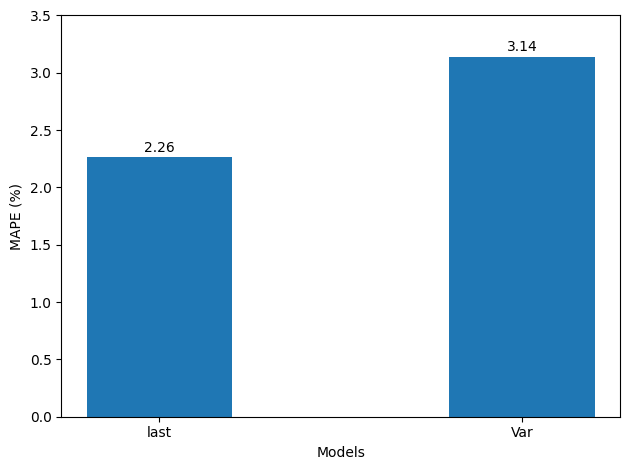

In [21]:
fig, ax = plt.subplots()
x = ['last', 'Var']
y = [mape_realdpi_last, mape_realdpi_VAR]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 3.5)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    plt.tight_layout()

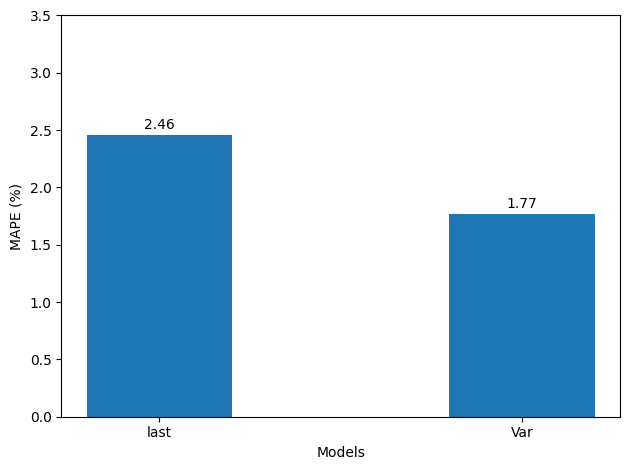

In [22]:
fig, ax = plt.subplots()
x = ['last', 'Var']
y = [mape_realcons_last, mape_realcons_VAR]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 3.5)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    plt.tight_layout()

En la figura puede ver que el modelo VAR(3) funciona peor que la línea de base en el caso de realdpi, pero mejor que la línea de base para realcons. Esta es una situación ambigua. No hay un resultado claro, ya que el modelo no supera la línea de base en ambas situaciones.

Podemos plantear la hipótesis de que, en el caso de realdpi, realcons no es lo suficientemente predictivo como para hacer pronósticos más precisos que la línea de base, aunque el Prueba de causalidad de Granger aprobada. Por lo tanto, deberíamos recurrir a utilizar una variación del modelo SARIMAX para predecir el realdpi. Por lo tanto, concluiría que el modelo VAR(3) no es suficiente para pronosticar con precisión realdpi y realcons. Sugeriría usar dos modelos separados, que podrían incluir realdpi y realcons como variables exógenas, al tiempo que podrían incluir el movimiento términos promedio.

# Proximos pasos

En este capítulo, cubrimos el modelo VAR(p), que nos permite pronosticar múltiples series temporales a la vez.

El modelo VAR(p) significa vector autorregresión, y asume que los valores pasados de algunas series temporales predicen los valores futuros de otras series temporales. Esta relación bidireccional se prueba mediante la prueba de causalidad de Granger. Si la prueba falla, lo que significa que los valores p devueltos son mayores que 0.05, el modelo VAR (p) no es válido y no se puede usar.

Felicitaciones por llegar tan lejos: ¡hemos cubierto una amplia gama de métodos estadísticos para pronosticar series temporales! Estos métodos estadísticos son ideal para conjuntos de datos más pequeños con baja dimensionalidad. `Sin embargo, cuando los conjuntos de datos comienzan a crecer, a partir de 10.000 puntos de datos o más`, y tienen muchas funciones, el aprendizaje profundo puede ser una gran herramienta para obtener pronósticos precisos y aprovechar todos los datos disponibles.

En el próximo capítulo, analizaremos un proyecto final para consolidar nuestro conocimiento de los métodos estadísticos. Luego comenzaremos una nueva sección y aplicaremos modelos de pronóstico de aprendizaje profundo en grandes conjuntos de datos.

# Resumen

- El modelo de autorregresión vectorial, VAR(p), captura la relación entre múltiples series a medida que cambian con el tiempo. En este modelo, cada serie tiene un impacto en las demás.
- Un modelo VAR(p) es válido solo si cada serie temporal causa de Granger a las otras. Esto se determina utilizando la prueba de causalidad de Granger.
- La hipótesis nula de la prueba de causalidad de Granger establece que una serie temporal no causa Granger a la otra. Si el valor p es menor que 0.05, rechazamos la hipótesis nula y concluimos que la primera serie temporal causa Granger a la otra.